In [ ]:
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 4.4 MB/s 
     |████████████████████████████████| 98 kB 6.0 MB/s 
     |████████████████████████████████| 45 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 18.4 MB/s 
     |████████████████████████████████| 47 kB 4.1 MB/s 
     |████████████████████████████████| 11.2 MB 40.7 MB/s 
     |████████████████████████████████| 957 kB 37.2 MB/s 
     |████████████████████████████████| 636 kB 8.0 MB/s 
     |████████████████████████████████| 281 kB 38.0 MB/s 
     |████████████████████████████████| 2.5 MB 48.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully

In [120]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb

import sdv.demo as demo
from sdv.tabular import CTGAN
from sdv.tabular import TVAE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

In [121]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult.csv


In [122]:
real_data = pd.read_csv('adult.csv')
real_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [123]:
#metadata , census_data = demo.load_demo('census', metadata = True)

In [125]:
#real_data = census_data['census']
#real_data.head()

In [126]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [127]:
#metadata.visualize()

In [128]:
real_data['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

In [129]:
real_data_subset = real_data.iloc[:15000]

In [130]:
real_data_subset['income'].value_counts(normalize=True)

<=50K    0.763
>50K     0.237
Name: income, dtype: float64

In [131]:
real_data_subset['income'].value_counts()

<=50K    11445
>50K      3555
Name: income, dtype: int64

**Build GAN**

In [132]:
model_gan = CTGAN(
              epochs=100,
              batch_size=100,
              generator_dim=(256, 256, 256),
              discriminator_dim=(256, 256, 256)
            )

In [133]:
model_gan.fit(real_data_subset)

In [134]:
#synthetic_data_gan = model_gan.sample(num_rows=15000)
#synthetic_data_gan.head()

In [135]:
#synthetic_data_gan['income'].value_counts(normalize=True)

In [136]:
from sdv.sampling import Condition

In [137]:
condition_0 = Condition({      
        'income': '<=50K'
          }, num_rows=11445)

condition_1 = Condition({      
        'income': '>50K'
          }, num_rows=3555)

In [138]:
gan_0 = model_gan.sample_conditions(conditions=[condition_0])
gan_1 = model_gan.sample_conditions(conditions=[condition_1])

Sampling conditions: 100%|██████████| 3555/3555 [00:01<00:00, 2089.63it/s]


In [139]:
synthetic_data_gan = pd.concat([gan_0,gan_1])
synthetic_data_gan.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,51,Private,135349,Bachelors,13,Married-civ-spouse,Adm-clerical,Not-in-family,White,Female,0,2012,40,United-States,<=50K
1,61,?,288569,Doctorate,6,Never-married,Exec-managerial,Not-in-family,Other,Female,36,0,30,United-States,<=50K
2,38,?,216311,HS-grad,7,Never-married,Handlers-cleaners,Not-in-family,Asian-Pac-Islander,Male,0,0,16,Guatemala,<=50K
3,25,Private,193941,HS-grad,7,Never-married,Other-service,Own-child,White,Female,0,0,29,United-States,<=50K
4,61,Private,226575,Bachelors,6,Divorced,Prof-specialty,Other-relative,Asian-Pac-Islander,Female,35,0,35,United-States,<=50K


In [140]:
synthetic_data_gan['income'].value_counts()

<=50K    11445
>50K      3555
Name: income, dtype: int64

In [141]:
synthetic_data_gan['income'].value_counts(normalize=True)

<=50K    0.763
>50K     0.237
Name: income, dtype: float64

In [142]:
#from google.colab import drive
#drive.mount('drive')

#synthetic_data_gan.to_csv('/content/drive/My Drive/synthetic_data_gan.csv', encoding='utf-8', index=False)

In [143]:
#from sdv.evaluation import evaluate
#evaluate(synthetic_data_gan,real_data_subset)

In [144]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']:
    synthetic_data_gan[i] = le.fit_transform(synthetic_data_gan[i].astype(str))

synthetic_data_gan.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,51,4,135349,9,13,2,1,1,4,0,0,2012,40,37,0
1,61,0,288569,10,6,4,3,1,3,0,36,0,30,37,0
2,38,0,216311,11,7,4,5,1,1,1,0,0,16,13,0
3,25,4,193941,11,7,4,7,3,4,0,0,0,29,37,0
4,61,4,226575,9,6,0,9,2,1,0,35,0,35,37,0


In [145]:
synthetic_data_gan['income'].value_counts(normalize=True)

0    0.763
1    0.237
Name: income, dtype: float64

In [146]:
scaler = StandardScaler()

X = scaler.fit_transform(synthetic_data_gan.drop('income', 1))
y = synthetic_data_gan['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3433
           1       0.54      0.72      0.62      1067

    accuracy                           0.79      4500
   macro avg       0.72      0.76      0.73      4500
weighted avg       0.82      0.79      0.80      4500



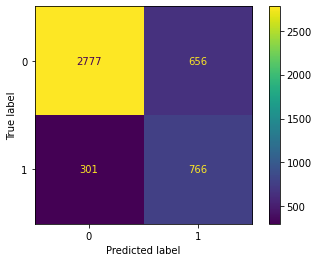

In [147]:
lgb_gan_synthetic = lgb.LGBMClassifier(class_weight='balanced')
lgb_gan_synthetic.fit(X_train, y_train)

y_pred = lgb_gan_synthetic.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_gan_synthetic, X_test, y_test)
plt.show()

In [148]:
f1_score(y_test, y_pred)

0.6155082362394535

Evaluate lgb_gan_synthetic on original dataset

In [149]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']:
    real_data_subset[i] = le.fit_transform(real_data_subset[i].astype(str))

real_data_subset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,38,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,38,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,38,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,38,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,38,0


In [150]:
scaler = StandardScaler()

X_evaluate = scaler.fit_transform(real_data_subset.drop('income', 1))
y_evaluate = real_data_subset['income'].values

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     11445
           1       0.53      0.68      0.59      3555

    accuracy                           0.78     15000
   macro avg       0.71      0.74      0.72     15000
weighted avg       0.80      0.78      0.79     15000



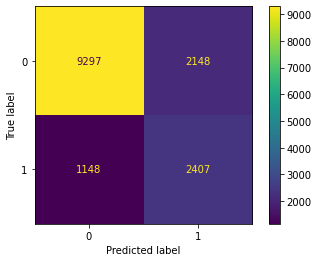

In [151]:
y_pred = lgb_gan_synthetic.predict(X_evaluate)

# evaluation
print(classification_report(y_evaluate, y_pred))
plot_confusion_matrix(lgb_gan_synthetic, X_evaluate, y_evaluate)
plt.show()

In [152]:
f1_score(y_evaluate, y_pred)

0.5935881627620222

**Build VAE**

In [153]:
real_data_subset = real_data.iloc[:15000]
real_data_subset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [154]:
real_data_subset['income'].value_counts(normalize=True)

<=50K    0.763
>50K     0.237
Name: income, dtype: float64

In [155]:
real_data_subset['income'].value_counts()

<=50K    11445
>50K      3555
Name: income, dtype: int64

In [156]:
model_vae = TVAE(
              epochs=100,
              batch_size=100,
              compress_dims=(256, 256, 256),
              decompress_dims=(256, 256, 256)
            )

In [157]:
model_vae.fit(real_data_subset)

In [158]:
#synthetic_data_vae = model_vae.sample(num_rows=15000)
#synthetic_data_vae.head()

In [159]:
#synthetic_data_vae['income'].value_counts(normalize=True)

In [160]:
from sdv.sampling import Condition

In [161]:
condition_0 = Condition({      
        'income': '<=50K'
          }, num_rows=11445)

condition_1 = Condition({      
        'income': '>50K'
          }, num_rows=3555)

In [162]:
vae_0 = model_vae.sample_conditions(conditions=[condition_0])
vae_1 = model_vae.sample_conditions(conditions=[condition_1])

Sampling conditions: 100%|██████████| 3555/3555 [00:00<00:00, 3662.85it/s]


In [163]:
synthetic_data_vae = pd.concat([vae_0,vae_1])
synthetic_data_vae.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,29,Private,123873,Some-college,10,Never-married,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
1,25,Private,105086,HS-grad,9,Never-married,Sales,Not-in-family,White,Female,1,0,40,United-States,<=50K
2,61,Private,211622,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
3,45,Private,136641,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,1,40,United-States,<=50K
4,38,Private,129477,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


In [164]:
synthetic_data_vae['income'].value_counts(normalize=True)

<=50K    0.763
>50K     0.237
Name: income, dtype: float64

In [165]:
synthetic_data_vae['income'].value_counts()

<=50K    11445
>50K      3555
Name: income, dtype: int64

In [166]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']:
    synthetic_data_vae[i] = le.fit_transform(synthetic_data_vae[i].astype(str))

synthetic_data_vae.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,29,3,123873,15,10,4,10,1,2,0,0,0,40,4,0
1,25,3,105086,11,9,4,10,1,2,0,1,0,40,4,0
2,61,3,211622,15,10,0,1,4,2,0,0,0,40,4,0
3,45,3,136641,15,10,2,12,0,2,1,0,1,40,4,0
4,38,3,129477,15,10,2,2,0,2,1,0,0,40,4,0


In [167]:
scaler = StandardScaler()

X = scaler.fit_transform(synthetic_data_vae.drop('income', 1))
y = synthetic_data_vae['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1)

              precision    recall  f1-score   support

           0       0.97      0.85      0.90      3433
           1       0.64      0.90      0.75      1067

    accuracy                           0.86      4500
   macro avg       0.81      0.87      0.83      4500
weighted avg       0.89      0.86      0.87      4500



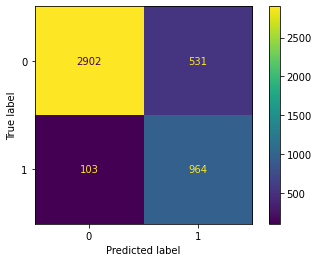

In [168]:
lgb_synthetic_vae = lgb.LGBMClassifier(class_weight='balanced')
lgb_synthetic_vae.fit(X_train, y_train)

y_pred = lgb_synthetic_vae.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_synthetic_vae, X_test, y_test)
plt.show()

In [169]:
f1_score(y_test, y_pred)

0.7525370804059329

Evaluate lgb_synthetic_vae on original dataset

In [170]:
real_data_subset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [171]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']:
    real_data_subset[i] = le.fit_transform(real_data_subset[i].astype(str))

real_data_subset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,38,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,38,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,38,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,38,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,38,0


In [172]:
scaler = StandardScaler()

X_evaluate = scaler.fit_transform(real_data_subset.drop('income', 1))
y_evaluate = real_data_subset['income'].values

              precision    recall  f1-score   support

           0       0.90      0.84      0.87     11445
           1       0.58      0.68      0.63      3555

    accuracy                           0.81     15000
   macro avg       0.74      0.76      0.75     15000
weighted avg       0.82      0.81      0.81     15000



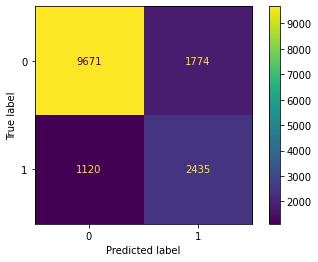

In [173]:
y_pred = lgb_synthetic_vae.predict(X_evaluate)

# evaluation
print(classification_report(y_evaluate, y_pred))
plot_confusion_matrix(lgb_synthetic_vae, X_evaluate, y_evaluate)
plt.show()

In [174]:
f1_score(y_evaluate, y_pred)

0.6272539927872232

**Build model on original data**

In [175]:
real_data_subset = real_data.iloc[:15000]
real_data_subset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [176]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']:
    real_data_subset[i] = le.fit_transform(real_data_subset[i].astype(str))

real_data_subset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,38,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,38,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,38,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,38,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,38,0


In [177]:
scaler = StandardScaler()

X = scaler.fit_transform(real_data_subset.drop('income', 1))
y = real_data_subset['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3433
           1       0.61      0.84      0.71      1067

    accuracy                           0.83      4500
   macro avg       0.78      0.84      0.79      4500
weighted avg       0.86      0.83      0.84      4500



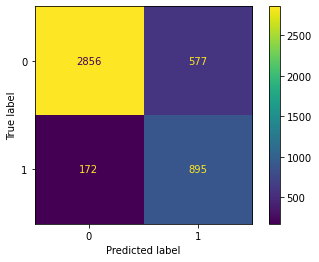

In [178]:
lgb_orig = lgb.LGBMClassifier(class_weight='balanced')
lgb_orig.fit(X_train, y_train)

y_pred = lgb_orig.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_orig, X_test, y_test)
plt.show()

In [179]:
f1_score(y_test, y_pred)

0.7050019692792437